adapted from: https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch

In [54]:
from tweedejaars_project import *
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import matplotlib.pyplot as plt
from datetime import datetime

In [55]:
features = [
    "import_capacity",
    "mid_price_published",
    "upward_dispatch_published",
    "downward_dispatch_published",
    # 'min_ptu_price_known',
    # "max_ptu_price_known",
    "settlement_price_bestguess",
    'PTU',
    'forecast_wind',
    'forecast_solar',
    'forecast_demand',
    'time_since_last_two_sided',
    'two_sided_daily_count',
    'ptu_id',
    'naive_strategy_action',
    'minute_in_ptu'
]
# already used
target = 'fix_two_sided_ptu'

df = load_df()

In [56]:
def interpolate_feature(df, features):
    for feature in features:
        df[feature] = df[feature].ffill()  # TODO: kan misschien linear ipv fill maar idk hoe goed dat gaat werken met live data
    return df

# Fix rows for NaNs where it is allowed
df = interpolate_feature(df, ['forecast_wind', 'forecast_solar', 'forecast_demand', "upward_dispatch_published", "downward_dispatch_published"])

def difference_published(df, features):
    values = [0., 1., 2., 3.]
    conditions = [
        (df[features[0]].notna() & df[features[1]].isna()),  # feature1 has value, feature2 is NaN
        (df[features[0]].isna() & df[features[1]].notna()),  # feature1 is NaN, feature2 has value
        (df[features[0]].isna() & df[features[1]].isna()),   # both feature1 and feature2 are NaN
        (df[features[0]].notna() & df[features[1]].notna())  # both feature1 and feature2 have values
    ]
    df['publish_info'] = np.select(conditions, values)
    return df

# bool ipv 2 feature waardes
df = difference_published(df, ['min_price_published', 'max_price_published'])

def fill_vals_0(df, features):
    for feature in features:
        df[feature] = df[feature].fillna(0)
    
    return df

df = fill_vals_0(df, ['min_ptu_price_known', 'max_ptu_price_known', 'settlement_price_bestguess'])



In [57]:
# Hyperparameters
input_dim =  len(features)
batch_size = 5 * len(features)
num_epochs = 1
learning_rate = 0.001
hidden_dim = 60   # hidden layer dimension
num_layers = 2    # number of hidden layers
output_dim = 1   # output dimension
seq_length = 15   # the number of time steps in each sequence

splits = get_splits(df, features)
# Split the data in vars
train_data = splits['train']
valid_data = splits['valid']
test_data = splits['test']

In [58]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data_in = pd.DataFrame(data['in']).astype(np.float32)
        self.data_out = pd.Series(data['out']).astype(np.float32)



    def __len__(self):
        return len(self.data_in)

    def __getitem__(self, idx):
        # np array sequence and target
        sequence = self.data_in.iloc[idx].values
        target = self.data_out.iloc[idx]

        sequence = torch.tensor(sequence, dtype=torch.float32)

        return sequence, torch.tensor(target, dtype=torch.float32)


In [59]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1])
        return out

In [60]:
model = RNNModel(input_dim, hidden_dim, num_layers, output_dim)

tensor_target = torch.tensor(train_data['out']).float()
criterion = nn.BCEWithLogitsLoss()
# pos_weight=(len(tensor_target)/ tensor_target.sum())*0.3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, amsgrad=True)

In [61]:
def prepare_data_loader(data, batch_size):
    dataset = TimeSeriesDataset(data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [62]:
train_loader = prepare_data_loader(train_data, batch_size)
valid_loader = prepare_data_loader(valid_data, batch_size)

In [63]:
def train_rnn(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()

    train_losses = []
    val_losses = []

    
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        
        # Training phase
        for batch_idx, (sequences, targets) in enumerate(train_loader):

            print(f"Training batch {batch_idx}, Sequence shape: {sequences.shape}")


            sequences = sequences.view(-1, seq_length, input_dim)
            targets = targets.unsqueeze(1)
        

            # Forward pass
            outputs = model(sequences)

            print(outputs.shape, targets.shape)
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss)

        
        # Validation phase
        model.eval()
        with torch.no_grad():
            for batch_idx, (sequences, targets) in enumerate(val_loader):

                print(f"Validation batch {batch_idx}, Sequence shape: {sequences.shape}")

                sequences = sequences.view(-1, seq_length, input_dim)
                targets = targets.unsqueeze(1)


                outputs = model(sequences)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
        val_losses.append(val_loss)


        train_loss /= len(train_loader)
        val_loss /= len(val_loader)


        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        # Switch back to training mode
        model.train()
        
    return train_losses, val_losses


train_losses, val_losses = train_rnn(model, train_loader, valid_loader, criterion, optimizer, num_epochs)

Training batch 0, Sequence shape: torch.Size([70, 14])


RuntimeError: shape '[-1, 15, 14]' is invalid for input of size 980

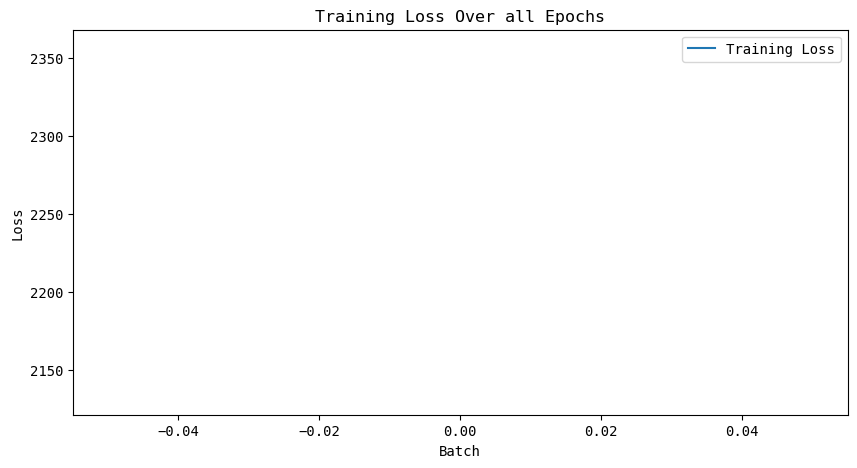

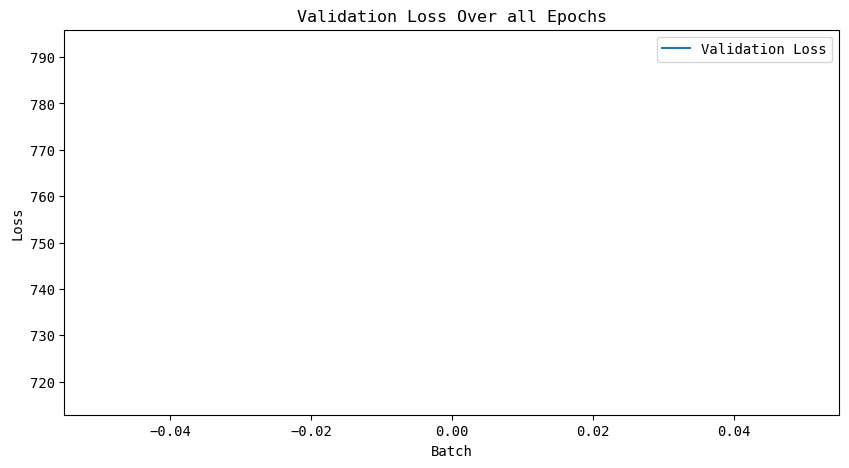

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over all Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Validation Loss Over all Epochs')
plt.legend()
plt.show()

In [ ]:
save_model(model, 'testing_rnn', 'rnn')

In [ ]:
def test_model(model, data_loader):
    model.eval()
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in data_loader:
            print('hello')
            sequences = sequences.view(-1, seq_length, input_dim)
            targets = targets.unsqueeze(1)

            # Forward pass
            outputs = model(sequences)
            all_outputs.append(outputs)
            all_targets.append(targets)
            
    return torch.cat(all_outputs), torch.cat(all_targets)

loaded_model = load_model('testing_rnn', 'rnn')
outputs, targets = test_model(loaded_model, valid_loader)

hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
hello
torch.Size([70, 14])
h

: 

In [ ]:
# Convert outputs to probabilities
probabilities = torch.sigmoid(outputs)
print(probabilities)
# Convert probabilities to binary predictions
predictions = (probabilities > 0.5).float()

# Evaluate the predictions
accuracy = (predictions == targets.unsqueeze(1)).float().mean()
print(f'Accuracy on valid set: {accuracy:.4f}')


tensor([[0.7311],
        [0.7311],
        [0.7311],
        ...,
        [0.7311],
        [0.7311],
        [0.7311]])


/home/sakr/anaconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sakr/anaconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sakr/anaconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

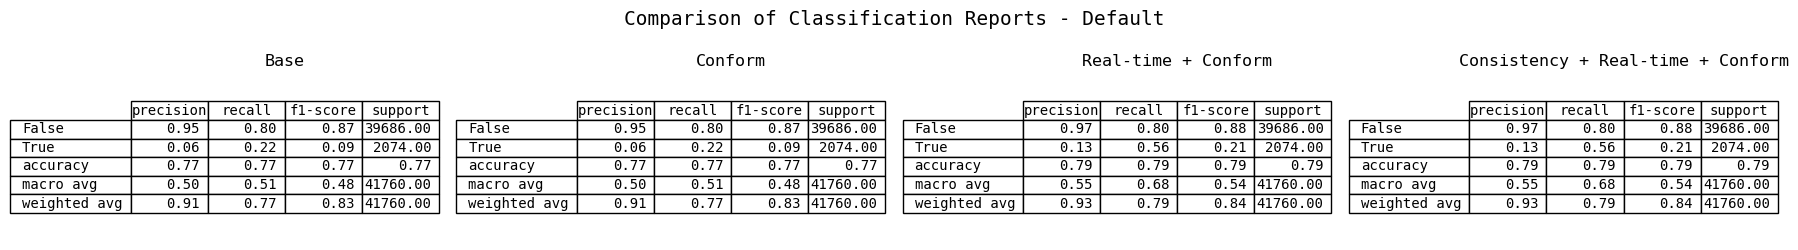

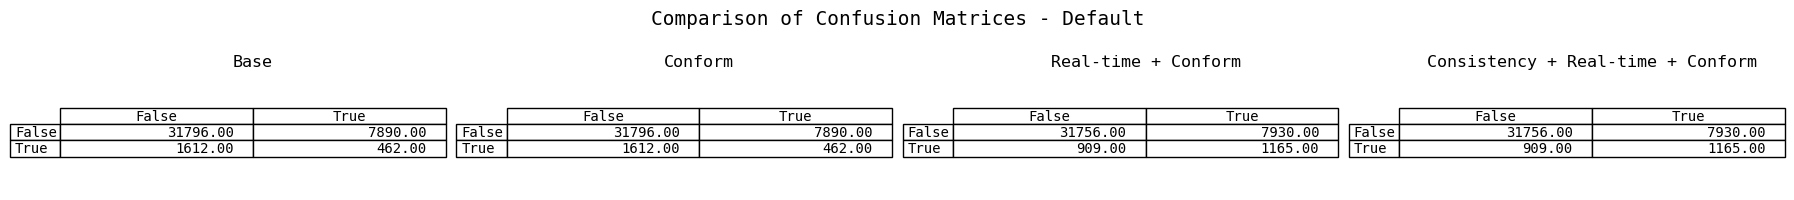

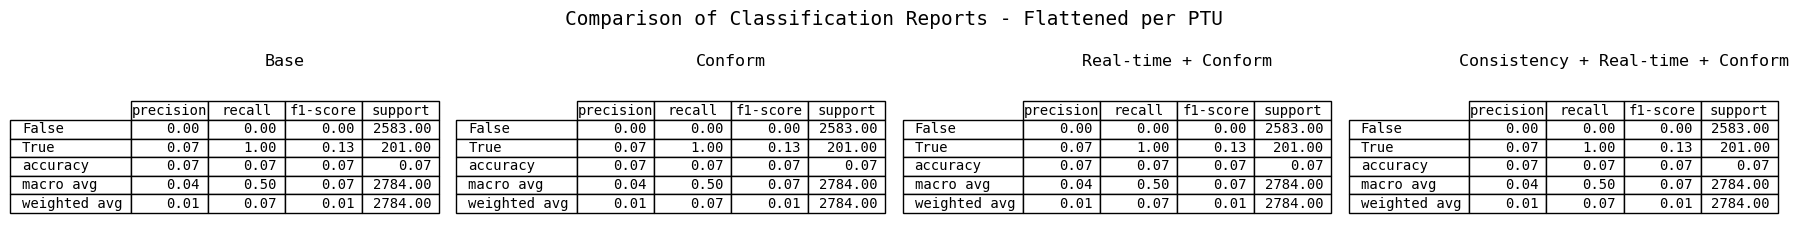

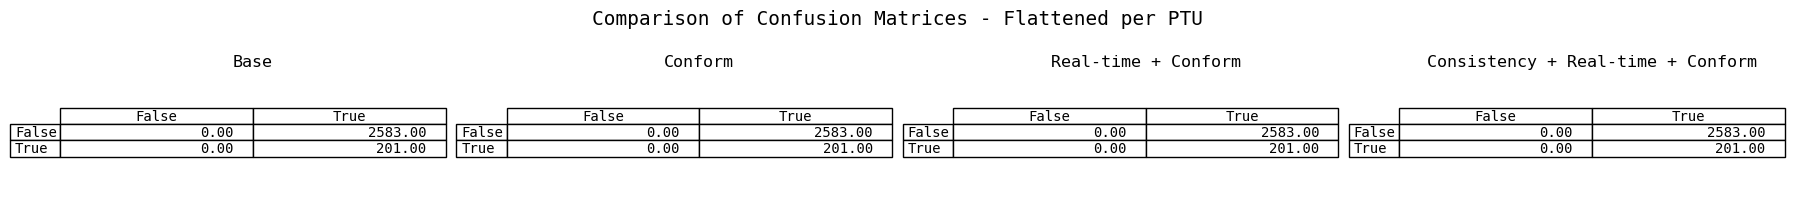

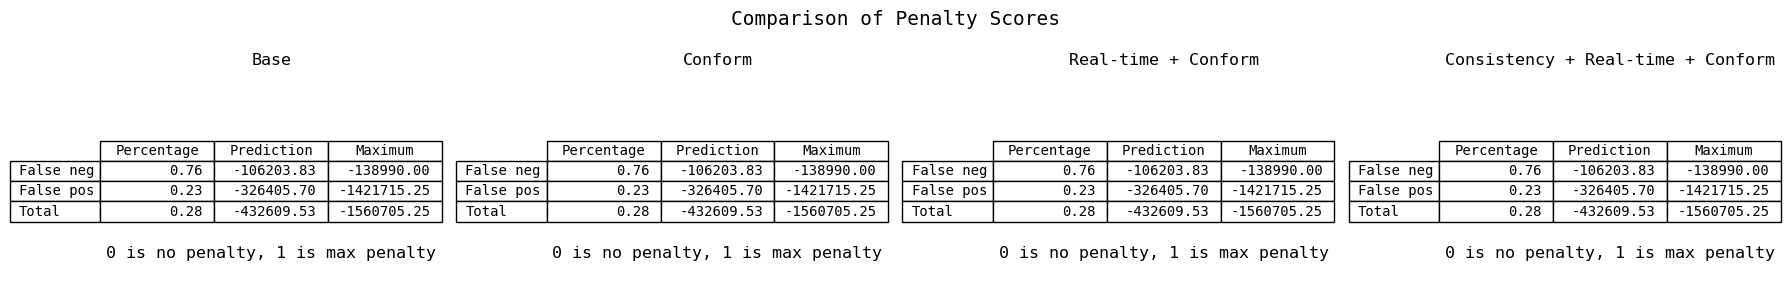

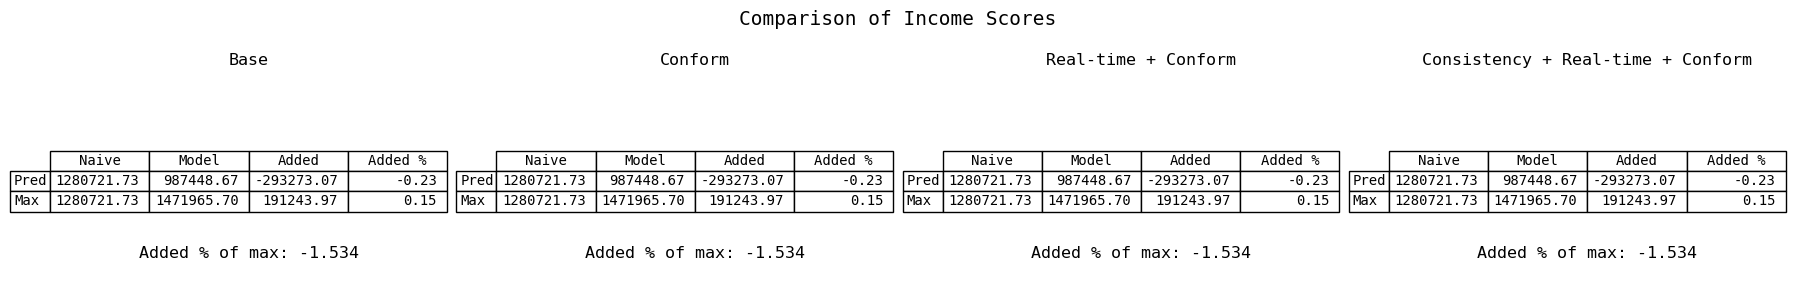

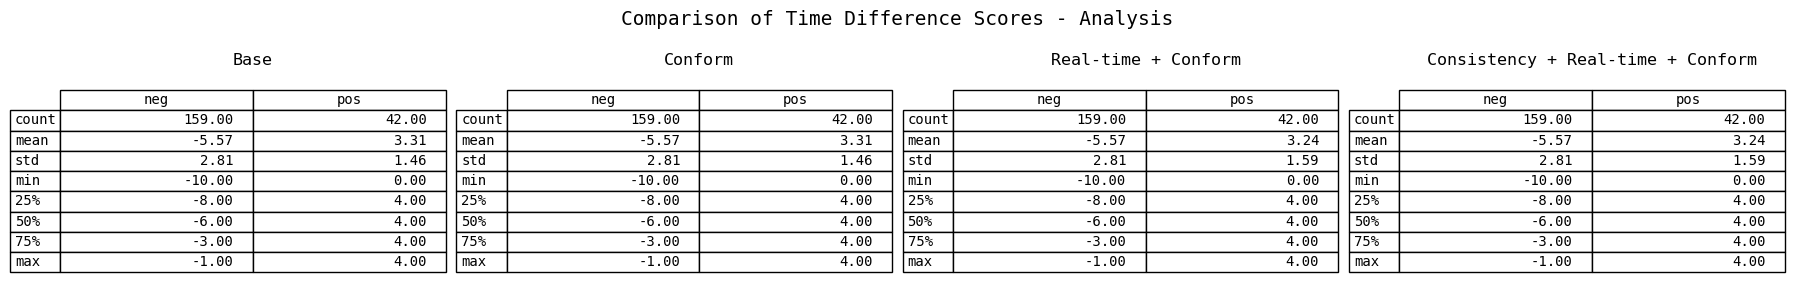

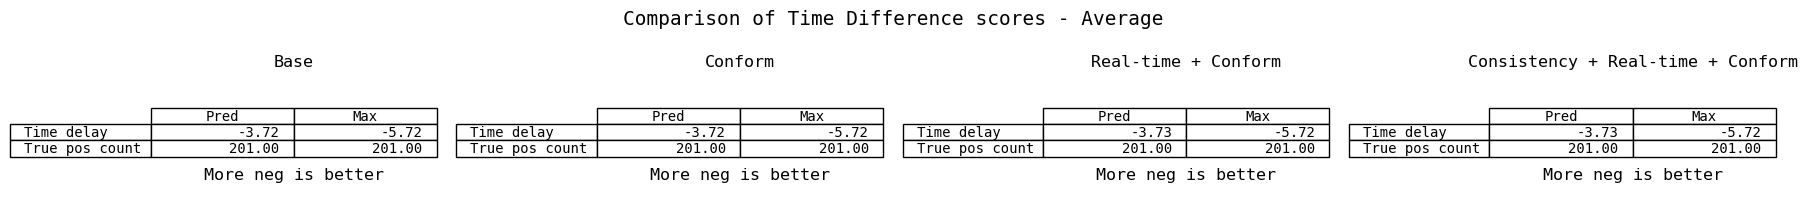

In [ ]:
df_pair = valid_data['df']

p1 = recast_pred(predictions.flatten())
show_metrics_adjusted(df_pair, p1)